In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import asdfghjkl
from torch.distributions import MultivariateNormal
from torch.autograd import grad

In [2]:
torch.manual_seed(1)
train_set_size = 100

g1 = MultivariateNormal(torch.tensor([4,4]), torch.eye(2))
g2 = MultivariateNormal(torch.tensor([2,2]), 0.5*torch.eye(2))
def get_lik(x):
    return train_set_size * (g1.log_prob(x).exp() + g2.log_prob(x).exp() / 2) # normalizing factor to scale to 1, multiply by train set size, assume all data comes from exactly same distribution



In [3]:
# define model
# map_model = torch.randn(2, requires_grad=True)
map_model = torch.tensor([2,4], dtype=torch.float, requires_grad=True)
map_tracking = map_model.detach().clone().unsqueeze(dim=0)
optimizer = torch.optim.SGD([map_model], lr=5e-4)

weight_prior_mean = 0
weight_prior_variance = 10
weight_prior = torch.distributions.MultivariateNormal(torch.full((1,2), weight_prior_mean), weight_prior_variance * torch.eye(2))

print("Computing MAP estimate")
epochs = 10000
for i in range(epochs):
    optimizer.zero_grad()
    # print(pred, train_target)
    log_lik = get_lik(map_model).log()
    log_prior = weight_prior.log_prob(map_model)
    loss = - (log_prior + log_lik)
    loss.backward()
    optimizer.step()
    map_tracking = torch.cat([map_tracking, map_model.detach().clone().unsqueeze(dim=0)], dim=0)
print(log_lik)

Computing MAP estimate
tensor(2.6165, grad_fn=<LogBackward0>)


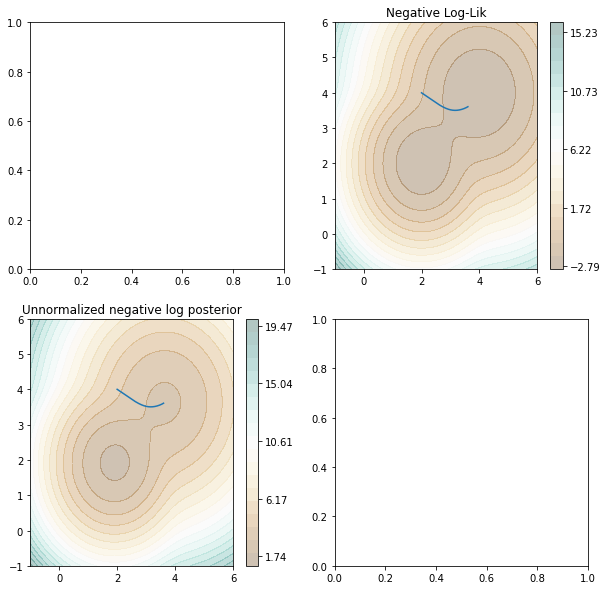

In [4]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flat

with torch.no_grad():
    padding = 1.5
    # x_bounds = (map_model[0] - padding, map_model[0] + padding)
    # y_bounds = (map_model[1] - padding, map_model[1] + padding)
    x_bounds = (-1, 6)
    y_bounds = x_bounds


    axs[1].plot(map_tracking[:,0], map_tracking[:,1], label="MAP")
    axs[2].plot(map_tracking[:,0], map_tracking[:,1], label="MAP")
    axs[1].set_title("Negative Log-Lik")

    n_weight_samples = 100
    weight_space_x = torch.linspace(x_bounds[0], x_bounds[1], n_weight_samples)
    weight_space_y = torch.linspace(y_bounds[0], y_bounds[1], n_weight_samples)
    # print("shape", weight_test_model[0].weight.data.shape)
    log_posterior_grid = torch.zeros((n_weight_samples, n_weight_samples))
    log_lik_grid = torch.zeros((n_weight_samples, n_weight_samples))
    for id1, weight1 in enumerate(weight_space_x):
        for id2, weight2 in enumerate(weight_space_y):
            new_weights = torch.tensor([[weight1, weight2]])
            log_lik = get_lik(new_weights).log()
            log_prior = weight_prior.log_prob(new_weights)
            log_posterior = (log_lik + log_prior)
            log_lik_grid[id1, id2] = -log_lik
            log_posterior_grid[id1, id2] = -log_posterior

cax2 = axs[1].contourf(weight_space_x, weight_space_y, log_lik_grid, cmap="BrBG", alpha=0.3, levels=20)
fig.colorbar(cax2, ax=axs[1], ticks=torch.linspace(log_lik_grid.min(), log_lik_grid.max(), 5))
cax3 = axs[2].contourf(weight_space_x, weight_space_y, log_posterior_grid, cmap="BrBG", alpha=0.3, levels=20)
fig.colorbar(cax3, ax=axs[2], ticks=torch.linspace(log_posterior_grid.min(), log_posterior_grid.max(), 5))
axs[2].set_title("Unnormalized negative log posterior");

In [5]:
# laplace model
# estimate the hessian
log_lik_hessian = asdfghjkl.hessian(-get_lik(map_model).log(), map_model)
log_prior_hessian = 2 / weight_prior_variance**2 # hessian of negative log gaussian
laplace_covariance = torch.inverse(log_lik_hessian + log_prior_hessian)
print(laplace_covariance)
laplace_distribution = torch.distributions.MultivariateNormal(map_model, laplace_covariance)


laplace_log_posterior_grid = torch.zeros((n_weight_samples, n_weight_samples))
with torch.no_grad():
    for id1, weight1 in enumerate(weight_space_x):
        for id2, weight2 in enumerate(weight_space_y):
            laplace_log_posterior_grid[id1, id2] = -laplace_distribution.log_prob(torch.tensor([weight1, weight2]))
cax4 = axs[3].contourf(weight_space_x, weight_space_y, laplace_log_posterior_grid, cmap="BrBG", alpha=0.3, levels=20)
fig.colorbar(cax4, ax=axs[3], ticks=torch.linspace(laplace_log_posterior_grid.min(), laplace_log_posterior_grid.max(), 5))
axs[3].set_title("Laplace approximation of posterior");

tensor([[1.0704, 0.0774],
        [0.0774, 1.0708]])


In [6]:
log_hessian_penatly_grid = torch.zeros((n_weight_samples, n_weight_samples))
for id1, weight1 in enumerate(weight_space_x):
    for id2, weight2 in enumerate(weight_space_y):
        model = torch.tensor([weight1, weight2], requires_grad=True)
        log_lik = get_lik(model).log()
        log_prior = weight_prior.log_prob(model)
        log_joint = (log_prior + log_lik).sum() # somehow have to do sum for asdl
        neg_log_joint_grad = grad(-log_joint, model, create_graph=True)[0]
        ggn = torch.outer(neg_log_joint_grad, neg_log_joint_grad)
        log_hessian = ggn.diag().log().sum()
        if torch.isinf(log_hessian) or torch.isnan(log_hessian):
            print("Log gessian is", log_hessian, ggn, neg_log_joint_grad)
        #     print(ggn, neg_log_joint_grad, -log_joint, model)
            raise ValueError
        loss = - log_joint + log_hessian
        log_hessian_penatly_grid[id1, id2] = loss.detach()
cax0 = axs[0].contourf(weight_space_x, weight_space_y, log_hessian_penatly_grid, cmap="Blues", alpha=0.3)#, levels=torch.linspace(log_hessian_penatly_grid.min(), log_hessian_penatly_grid.max(), 20))
fig.colorbar(cax0, ax=axs[0], ticks=torch.linspace(log_hessian_penatly_grid.min(), log_hessian_penatly_grid.max(), 10))
axs[0].set_title("Loss landscape for log hessian penatly")



# define model
lvi_model = map_tracking[0].detach().clone()
lvi_model.requires_grad = True
lvi_tracking = lvi_model.detach().clone().unsqueeze(dim=0)
lvi_optimizer = torch.optim.SGD([lvi_model], lr=5e-4)

weight_prior_mean = 0
weight_prior_variance = 2
weight_prior = torch.distributions.MultivariateNormal(torch.full((1,2), weight_prior_mean), weight_prior_variance * torch.eye(2))

print("Computing Log-Hessian penalty")
for i in range(epochs):
    lvi_optimizer.zero_grad()
    # print(pred, train_target)
    log_lik = get_lik(lvi_model).log()
    log_prior = weight_prior.log_prob(lvi_model)
    log_joint = (log_prior + log_lik).sum() # somehow have to do sum for asdl
    neg_log_joint_grad = grad(-log_joint, lvi_model, create_graph=True)[0]
    ggn = torch.outer(neg_log_joint_grad, neg_log_joint_grad)
    log_hessian = ggn.diag().log().sum()
    loss = - log_joint + 0.01*log_hessian#asdfghjkl.hessian(-log_joint, lvi_model, create_graph=True).log().sum()
    # print(i, -log_joint, ggn, log_hessian)
    loss.backward()
    lvi_optimizer.step()
    lvi_tracking = torch.cat([lvi_tracking, lvi_model.detach().clone().unsqueeze(dim=0)], dim=0)

# print(lvi_tracking)
axs[1].plot(lvi_tracking[:,0], lvi_tracking[:,1], label="Laplace_VI")
axs[2].plot(lvi_tracking[:,0], lvi_tracking[:,1], label="Laplace_VI")
axs[0].plot(lvi_tracking[:,0], lvi_tracking[:,1], label="Laplace_VI")
axs[1].legend()

plt.tight_layout();
# Variational inference


Computing Log-Hessian penalty


<Figure size 432x288 with 0 Axes>

In [7]:
vi_weight_mean = map_tracking[0].detach().clone()
vi_weight_mean.requires_grad = True
var = 1
vi_weight_std = torch.full((2,), var, dtype=torch.float, requires_grad=True)
vi_optimizer = torch.optim.SGD([vi_weight_mean, vi_weight_std], lr=5e-4)
vi_weight_mean_tracking = vi_weight_mean.detach().clone().unsqueeze(dim=0)
for i in range(epochs):
    vi_optimizer.zero_grad()
    weight_samples = vi_weight_mean + vi_weight_std * torch.randn(2)
    log_lik = get_lik(weight_samples).log()
    log_prior = weight_prior.log_prob(weight_samples)
    log_joint = (log_prior + log_lik)
    entropy = vi_weight_std.log().sum()
    loss = - log_joint - entropy
    loss.backward()
    vi_optimizer.step()
    vi_weight_mean_tracking = torch.cat([vi_weight_mean_tracking, vi_weight_mean.detach().clone().unsqueeze(dim=0)], dim=0)

axs[1].plot(vi_weight_mean_tracking[:,0], vi_weight_mean_tracking[:,1], label="normal VI")
axs[2].plot(vi_weight_mean_tracking[:,0], vi_weight_mean_tracking[:,1], label="normal VI")
axs[0].plot(vi_weight_mean_tracking[:,0], vi_weight_mean_tracking[:,1], label="normal VI")
axs[0].legend();
axs[1].legend();
axs[2].legend();

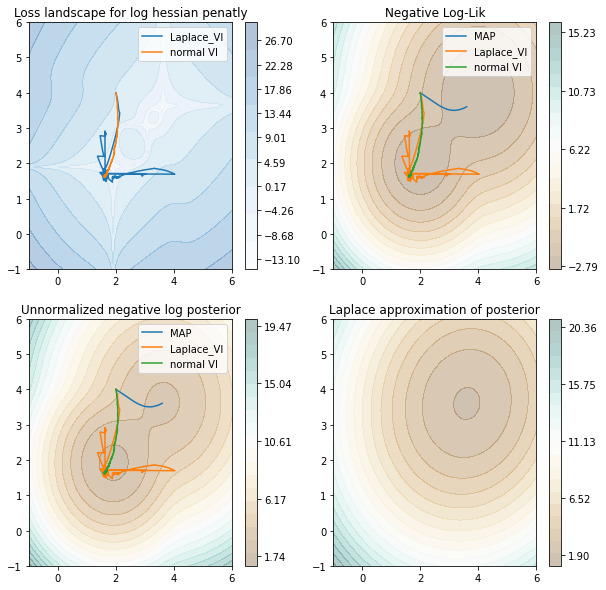

In [8]:
fig